In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import tqdm
import pickle
import scipy
import matplotlib
import numpy as np
import pandas as pd
import ase.io as aio
import seaborn as sns

from toolz.curried import pipe, curry, compose

import warnings
warnings.filterwarnings('ignore')

In [3]:
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC
from sklearn.manifold import TSNE, MDS
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

In [5]:
import atom_stat as astat
import utilities as utils

In [6]:
get_atoms = lambda a: Atoms(["Cu"]*len(a),
                            positions=a.get_positions(),
                            cell=a.get_cell(), 
                            pbc=[1, 1, 1], 
                            tags=a.get_tags())

In [7]:
runs = np.loadtxt("runs.txt").astype(int)

### When computing for damaged structures, atoms corresponding to the damaged region are considered.

In [8]:
ix=-1
atoms = pipe("data/structs/dump.arc.{}_atom.pkl".format(runs[ix]), 
             lambda f: utils.load_file(f))

No. of disturbed atoms: 278104


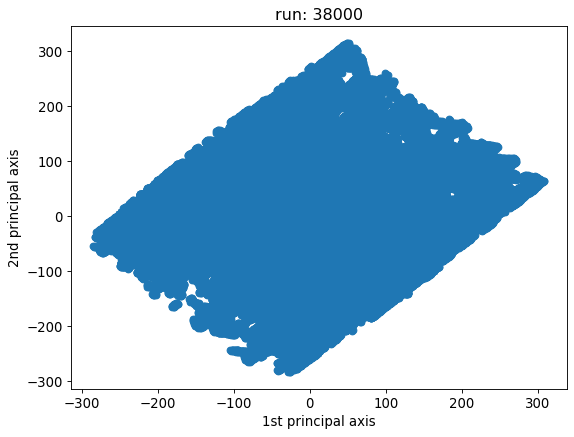

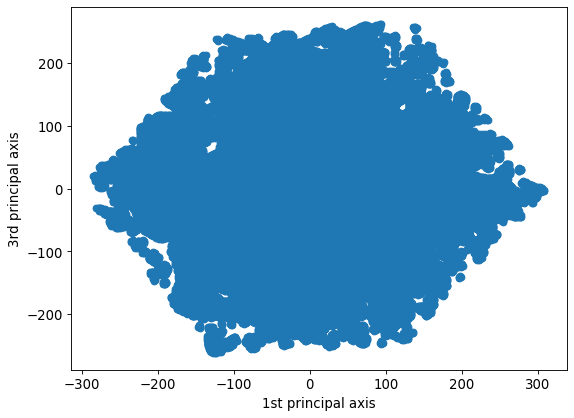

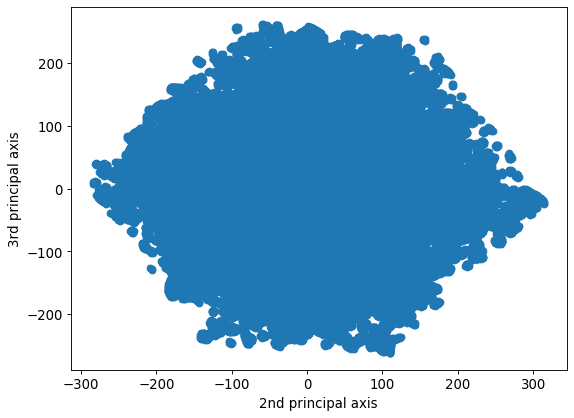

CPU times: user 8.28 s, sys: 169 ms, total: 8.45 s
Wall time: 4.94 s


In [9]:
%%time
idx = np.where(atoms.get_tags() != 1)[0]
print("No. of disturbed atoms: {}".format(len(idx)))

coords_all = atoms.get_positions()
coords_sub = coords_all[idx]

pca = PCA(n_components=3)
scores = pca.fit_transform(coords_sub)
plt.scatter(scores[:,0], scores[:,1])
plt.xlabel("1st principal axis")
plt.ylabel("2nd principal axis")
plt.title("run: {}".format(runs[ix]))
plt.show()

plt.scatter(scores[:,0], scores[:,2])
plt.xlabel("1st principal axis")
plt.ylabel("3rd principal axis")
plt.show()

plt.scatter(scores[:,1], scores[:,2])
plt.xlabel("2nd principal axis")
plt.ylabel("3rd principal axis")
plt.show()

In [10]:
print(scipy.stats.moment(scores, 1, 0))
print(np.sqrt(scipy.stats.moment(scores, 2, 0)))
print(np.fabs(scipy.stats.moment(scores, 3, 0))**0.33*np.sign(scipy.stats.moment(scores, 3, 0)))
print(scipy.stats.moment(scores, 4, 0)**0.25)

[0. 0. 0.]
[111.83465925 104.6615895  100.34869532]
[ 18.93009652 -31.90115167 -33.21744517]
[140.34202599 132.37062345 126.14530293]


## Analysis over all structures

In [12]:
features = []
vols = []
n_atoms_all = []
n_atoms_irr = []

for run in tqdm.tqdm_notebook(runs):

    atoms = pipe("data/structs/dump.arc.{}_atom.pkl".format(run), 
             lambda f: utils.load_file(f))
    
    atoms.set_chemical_symbols(["Cu"]*len(atoms))
    indxs = np.where(atoms.get_tags() != 1)[0]

    vols.append(atoms.get_volume())
    n_atoms_all.append(len(atoms))
    n_atoms_irr.append(len(indxs))

    if len(indxs) != 0:
        coords_all = atoms.get_positions()
        coords_sub = coords_all[indxs]
        pca = PCA(n_components=3)
        scores = pca.fit_transform(coords_sub)
        m_crd = scipy.stats.moment(coords_sub, 2, 0)
        m_pca = scipy.stats.moment(scores, 2, 0)
        features.append(np.concatenate([np.array([n_atoms_irr[-1]]), m_crd, m_pca, pca.explained_variance_]))
    else:
        continue



In [23]:
utils.save_file(fname="data/scalers_all.pkl", obj=features)
utils.save_file("data/scalers_tot_atom_count.pkl", obj=n_atoms_all)
utils.save_file("data/scalers_irr_atom_count.pkl", obj=n_atoms_irr)
utils.save_file("data/scalers_box_volume.pkl", obj=vols)

# Anlysis using preloaded data

In [26]:
n_atoms_all = utils.load_file("data/scalers_tot_atom_count.pkl")
n_atoms_irr = utils.load_file("data/scalers_irr_atom_count.pkl")
vols = utils.load_file("data/scalers_box_volume.pkl")

In [28]:
indxs = np.where(np.asarray(n_atoms_irr)!=0)[0]
print("No. of structures: {}".format(len(indxs)))

features = utils.load_file("data/scalers_all.pkl")
s_data = np.concatenate([np.array(f)[None] for f in features])

No. of structures: 76


In [29]:
cols = ["m2_x_xyz", "m2_y_xyz", "m2_z_xyz", "m2_x", 
        "m2_y", "m2_z", "vol", "var1", "var2", 
        "var3", "m3_x", "m3_y", "m3_z", "m4_x", 
        "m4_y", "m4_z", "n_atoms_irr", "n_atoms_all"]

arr = np.concatenate([s_data, 
                      np.asarray(n_atoms_irr)[indxs][...,None], 
                      (np.asarray(n_atoms_all))[indxs][...,None]], 
                     axis=1)

df = pd.DataFrame(arr, columns=[str(item) for item in range(arr.shape[1])])
df = pd.DataFrame(arr, columns=cols)
df.to_csv("scalers_all.csv")

In [30]:
df = pd.read_csv("scalers_all.csv", index_col=0)

In [38]:
df["m2_x2"] = df["m2_x"]**2
df["m2_y2"] = df["m2_y"]**2
df["m3_x3"] = df["m3_x"]**3
df["m3_y3"] = df["m3_y"]**3
df["m4_x4"] = df["m4_x"]**4
df["m4_y4"] = df["m4_y"]**4

df["scaled_m2_x"] = df["m2_x2"]*df["n_atoms_irr"]
df["scaled_m2_y"] = df["m2_y2"]*df["n_atoms_irr"]
df["scaled_m3_x"] = df["m3_x3"]*df["n_atoms_irr"]
df["scaled_m3_y"] = df["m3_y3"]*df["n_atoms_irr"]
df["scaled_m4_x"] = df["m4_x4"]*df["n_atoms_irr"]
df["scaled_m4_y"] = df["m4_y4"]*df["n_atoms_irr"]

df["m2_x2_norm"] =  (df["m2_x2"] - df["m2_x2"].mean())/np.std(df["m2_x2"])
df["m3_x3_norm"] =  (df["m3_x3"] - df["m3_x3"].mean())/np.std(df["m3_x3"])
df["m4_x4_norm"] =  (df["m4_x4"] - df["m4_x4"].mean())/np.std(df["m4_x4"])

df["m2_x_norm"] =  df["m2_x2"]/df["m2_x2"].std()
df["m2_y_norm"] =  df["m2_y2"]/df["m2_y2"].std()


df["m3_x_norm"] =  df["m3_x3"]/df["m3_x3"].std()
df["m3_y_norm"] =  df["m3_y3"]/df["m3_y3"].std()


df["m4_x_norm"] =  df["m4_x4"]/df["m4_x4"].std()
df["m4_y_norm"] =  df["m4_y4"]/df["m4_y4"].std()


df["var1_norm"] = df["var1"]/df["var1"].std()
df["var2_norm"] = df["var2"]/df["var2"].std()
df["var3_norm"] = df["var3"]/df["var3"].std()

df["n_atoms_irr_norm"] =  df["n_atoms_irr"]/df["n_atoms_irr"].std()

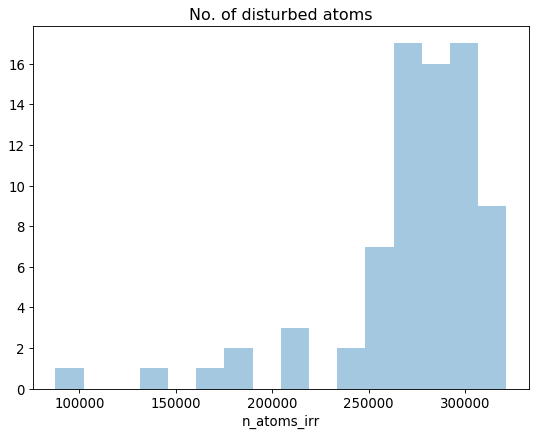

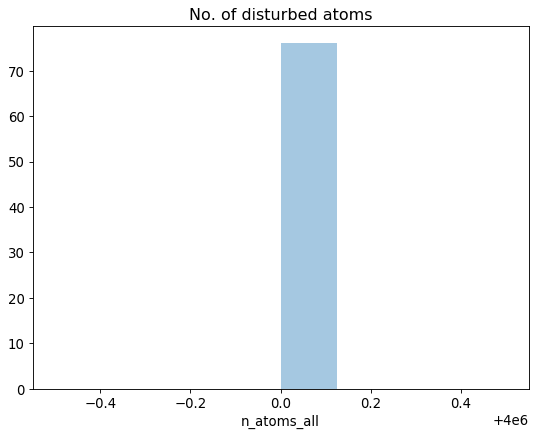

In [37]:
sns.distplot(df["n_atoms_irr"], kde=False)
plt.title("No. of disturbed atoms")
plt.show()

sns.distplot(df["n_atoms_all"], kde=False )
plt.title("No. of disturbed atoms")
plt.show()

## Load and concatenate RDF signals

In [29]:
r_stat = 50
len_pixel = 50
nbins = (r_stat+2)*len_pixel+1
bins = np.linspace(0.0, r_stat+2, nbins)[1:]

p_spiky = load_file("cu_rdf_spiky_01_periodic.pkl")
# p_spiky = load_file("cu_rdf_spiky_01.pkl")
kernel = astat.epanechnikov_kernel(width=0.5, x=bins)
p_smooth = []
for pdf in p_spiky:
    new_pdf = astat.convolve_kernel(kernel, pdf)
    p_smooth.append(new_pdf)
    
kernel = astat.epanechnikov_kernel(width=1.0, x=bins)
p_smooth_1 = []
for pdf in p_spiky:
    new_pdf = astat.convolve_kernel(kernel, pdf)
    p_smooth_1.append(new_pdf)

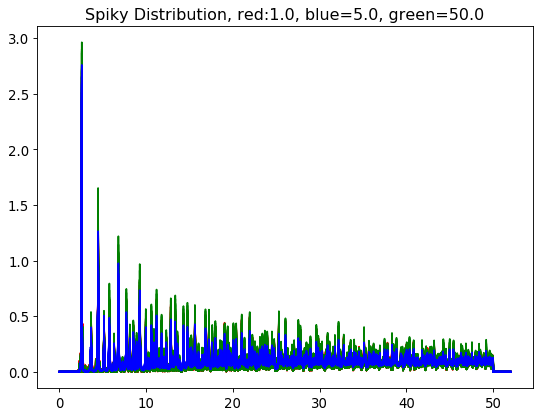

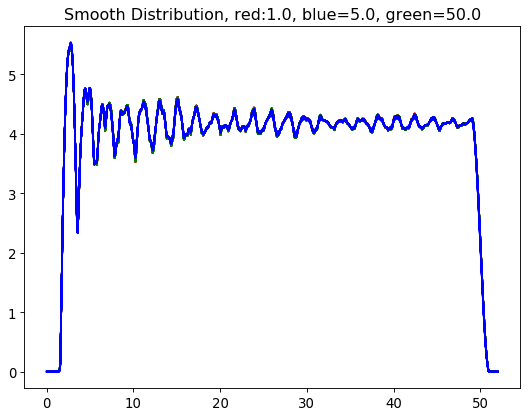

In [32]:
n_samples = 20

np.random.seed(209374)
for i in np.random.randint(50, 90, n_samples):
    plt.plot(bins, p_spiky[i], "r")
    
for i in np.random.randint(150, 190, n_samples):
    plt.plot(bins, p_spiky[i], "g")
    
for i in np.random.randint(301, 343, n_samples):
    plt.plot(bins, p_spiky[i], "b")

plt.title("Spiky Distribution, red:1.0, blue=5.0, green=50.0")
plt.show()


n_samples = 20

for i in np.random.randint(50, 90, n_samples):
    plt.plot(bins, p_smooth_1[i], "r")
    
for i in np.random.randint(151, 190, n_samples):
    plt.plot(bins, p_smooth_1[i], "g")
    
for i in np.random.randint(301, 343, n_samples):
    plt.plot(bins, p_smooth_1[i], "b")

plt.title("Smooth Distribution, red:1.0, blue=5.0, green=50.0")
plt.show()

# for i in np.random.randint(0, len(p_spiky), n_samples):
#     plt.plot(bins, p_smooth[i])
# plt.title("Smooth Distribution")
# plt.show()

# for i in np.random.randint(0, len(p_spiky), n_samples):
#     plt.plot(bins, p_smooth_1[i])
# plt.title("Extra Smooth Distribution")
# plt.show()

In [33]:
rdf_data = np.concatenate([item[None] for item in p_smooth_1], axis=0)
print(rdf_data.shape)

(343, 2600)


In [34]:
tda_data = load_file("cu_tda_smooth_5.pkl")
print(tda_data.shape)

(343, 100000)


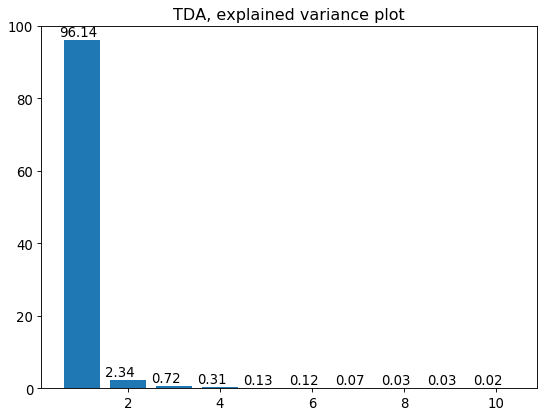

In [36]:
pca = PCA(n_components=10)
scores = pca.fit_transform(tda_data)
ex_var = pca.explained_variance_ratio_ * 100
plt.bar(np.arange(1, 11), ex_var)
plt.ylim([0, 100])
for ix, item in enumerate(ex_var):
    plt.text(ix+0.5, item+1.0, "{:1.2f}".format(item))
plt.title("TDA, explained variance plot")
plt.show()

In [27]:
pca = PCA(n_components=10)
scores = pca.fit_transform(rdf_data)
ex_var = pca.explained_variance_ratio_ * 100
plt.bar(np.arange(1, 11), ex_var)
plt.ylim([0, 100])
for ix, item in enumerate(ex_var):
    plt.text(ix+0.5, item+1.0, "{:1.2f}".format(item))
plt.title("RDF, explained variance plot")
plt.show()

NameError: name 'rdf_data' is not defined

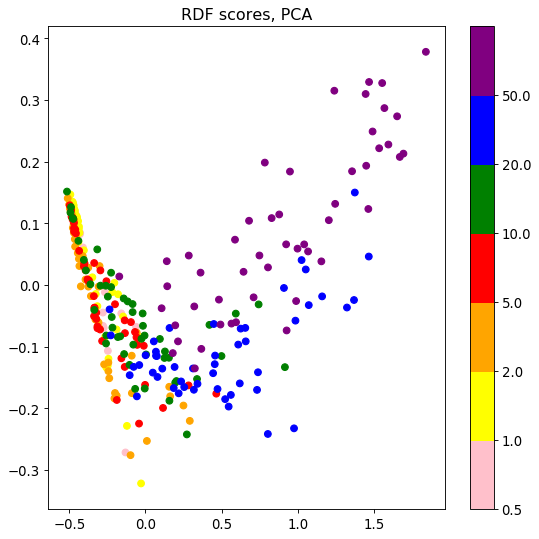

CPU times: user 1.52 s, sys: 14.5 ms, total: 1.54 s
Wall time: 196 ms


In [39]:
%%time
X_emb = PCA(n_components=2).fit_transform(rdf_data)

label = np.ravel([[i]*nrun for i in range(len(pka_list))])[indxs]
colors = ['pink', 'yellow', 'orange', 'red','green','blue', 'purple']

fig = plt.figure(figsize=(8,8))
plt.scatter(X_emb[:,0], X_emb[:,1], c=label, cmap=matplotlib.colors.ListedColormap(colors))

cb = plt.colorbar()
loc = np.arange(0,max(label),max(label)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels([str(item/1000) for item in pka_list])

plt.title("RDF scores, PCA")
plt.show()

The key characteristic of t-SNE is that it solves a problem known as the crowding problem. The extent to which this problem occurs depends on the ratio between the intrinsic data dimensionality and the embedding dimensionality. So, if you embed in, say, thirty dimensions, the crowding problem is less severe than when you embed in two dimensions. 

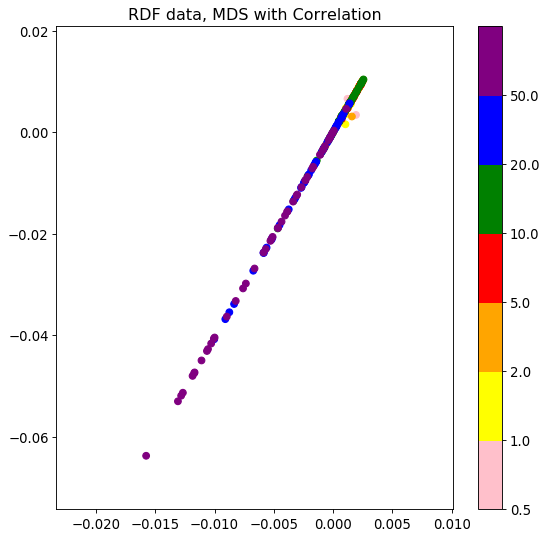

CPU times: user 6.7 s, sys: 62.1 ms, total: 6.77 s
Wall time: 989 ms


In [86]:
%%time
dmat = squareform(pdist(rdf_data, "correlation"))*100
seed = 29734
mds = MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=seed,
                   dissimilarity="precomputed", n_jobs=1)
X_emb = mds.fit(dmat).embedding_

label = np.ravel([[i]*nrun for i in range(len(pka_list))])[indxs]
colors = ['pink', 'yellow', 'orange', 'red','green','blue', 'purple']

fig = plt.figure(figsize=(8,8))
plt.scatter(X_emb[:,0], X_emb[:,1], c=label, cmap=matplotlib.colors.ListedColormap(colors))

cb = plt.colorbar()
loc = np.arange(0,max(label),max(label)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels([str(item/1000) for item in pka_list])

plt.title("RDF data, MDS with Correlation")
plt.show()

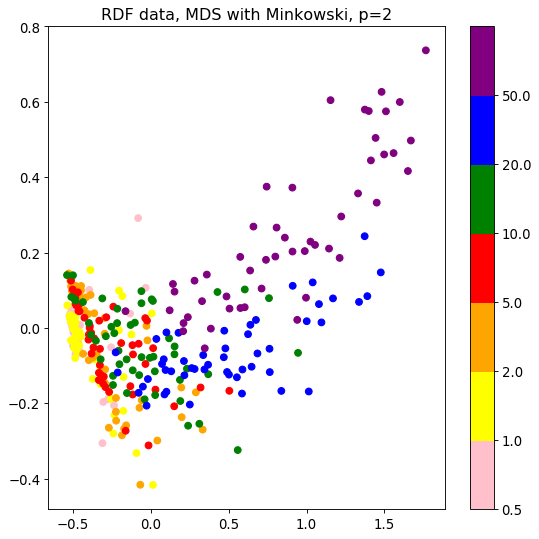

CPU times: user 44 s, sys: 354 ms, total: 44.3 s
Wall time: 7.83 s


In [44]:
%%time
dmat = squareform(pdist(rdf_data, "minkowski", p=2))
seed = 29734
mds = MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=seed,
                   dissimilarity="precomputed", n_jobs=1)
X_emb = mds.fit(dmat).embedding_

label = np.ravel([[i]*nrun for i in range(len(pka_list))])[indxs]
colors = ['pink', 'yellow', 'orange', 'red','green','blue', 'purple']

fig = plt.figure(figsize=(8,8))
plt.scatter(X_emb[:,0], X_emb[:,1], c=label, cmap=matplotlib.colors.ListedColormap(colors))

cb = plt.colorbar()
loc = np.arange(0,max(label),max(label)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels([str(item/1000) for item in pka_list])

plt.title("RDF data, MDS with Minkowski, p=2")
plt.show()

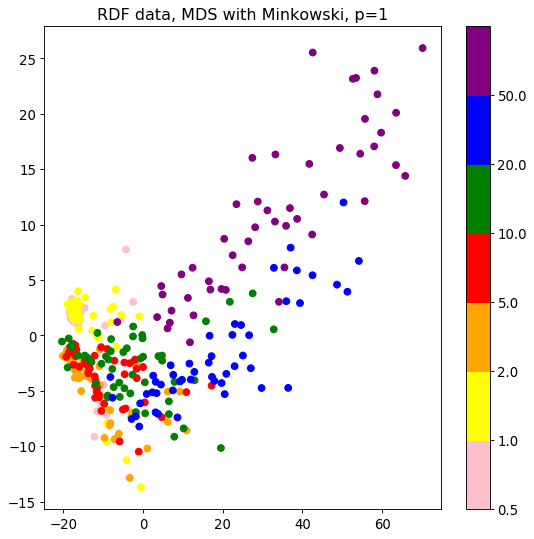

CPU times: user 41.3 s, sys: 350 ms, total: 41.6 s
Wall time: 7.5 s


In [45]:
%%time
dmat = squareform(pdist(rdf_data, "minkowski", p=1))
seed = 29734
mds = MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=seed,
                   dissimilarity="precomputed", n_jobs=1)
X_emb = mds.fit(dmat).embedding_

label = np.ravel([[i]*nrun for i in range(len(pka_list))])[indxs]
colors = ['pink', 'yellow', 'orange', 'red','green','blue', 'purple']

fig = plt.figure(figsize=(8,8))
plt.scatter(X_emb[:,0], X_emb[:,1], c=label, cmap=matplotlib.colors.ListedColormap(colors))

cb = plt.colorbar()
loc = np.arange(0,max(label),max(label)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels([str(item/1000) for item in pka_list])

plt.title("RDF data, MDS with Minkowski, p=1")
plt.show()

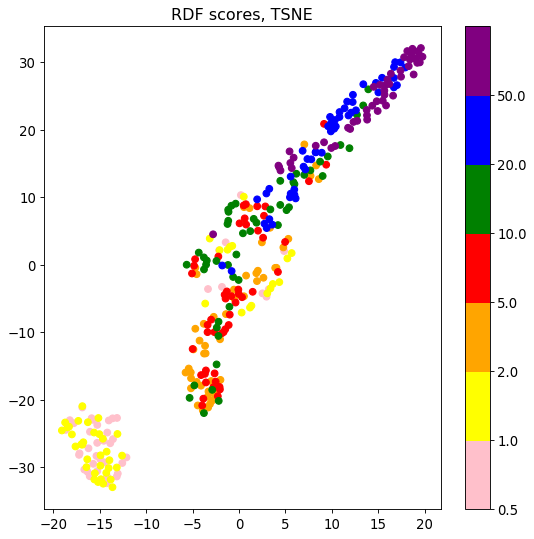

CPU times: user 14.2 s, sys: 528 ms, total: 14.7 s
Wall time: 993 ms


In [87]:
%%time
scores = PCA(n_components=100).fit_transform(rdf_data)
X_emb = TSNE(n_components=2).fit_transform(scores)

label = np.ravel([[i]*nrun for i in range(len(pka_list))])[indxs]
colors = ['pink', 'yellow', 'orange', 'red','green','blue', 'purple']

fig = plt.figure(figsize=(8,8))
plt.scatter(X_emb[:,0], X_emb[:,1], c=label, cmap=matplotlib.colors.ListedColormap(colors))

cb = plt.colorbar()
loc = np.arange(0,max(label),max(label)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels([str(item/1000) for item in pka_list])

plt.title("RDF scores, TSNE")
plt.show()

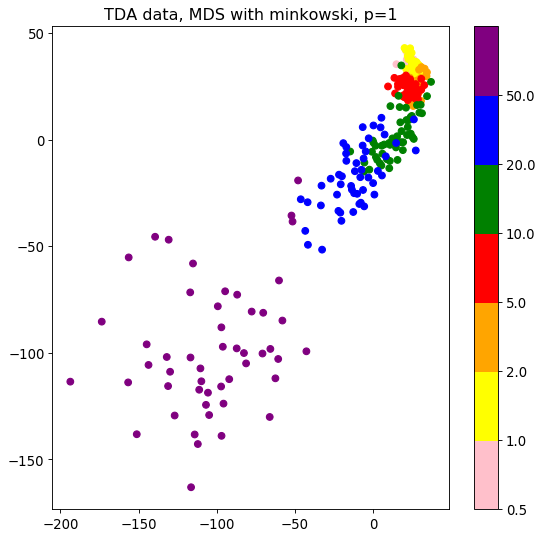

CPU times: user 3min 2s, sys: 1.44 s, total: 3min 4s
Wall time: 1min 19s


In [60]:
%%time
dmat = squareform(pdist(tda_data, "minkowski", p=1))
seed = 29734
mds = MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=seed,
                   dissimilarity="precomputed", n_jobs=1)
X_emb = mds.fit(dmat).embedding_

label = np.ravel([[i]*nrun for i in range(len(pka_list))])[indxs]
colors = ['pink', 'yellow', 'orange', 'red','green','blue', 'purple']

fig = plt.figure(figsize=(8,8))
plt.scatter(X_emb[:,0], X_emb[:,1], c=label, cmap=matplotlib.colors.ListedColormap(colors))

cb = plt.colorbar()
loc = np.arange(0,max(label),max(label)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels([str(item/1000) for item in pka_list])

plt.title("TDA data, MDS with minkowski, p=1")
plt.show()

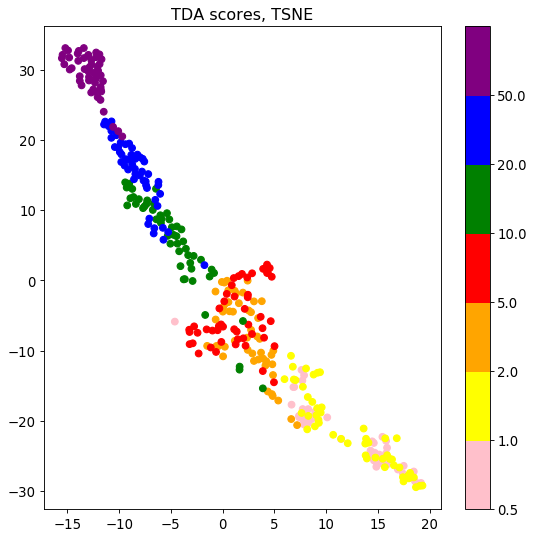

CPU times: user 29.7 s, sys: 1.88 s, total: 31.6 s
Wall time: 3.13 s


In [39]:
%%time
scores = PCA(n_components=100).fit_transform(tda_data)
X_emb = TSNE(n_components=2).fit_transform(scores)

label = np.ravel([[i]*nrun for i in range(len(pka_list))])[indxs]
colors = ['pink', 'yellow', 'orange', 'red','green','blue', 'purple']

fig = plt.figure(figsize=(8,8))
plt.scatter(X_emb[:,0], X_emb[:,1], c=label, cmap=matplotlib.colors.ListedColormap(colors))

cb = plt.colorbar()
loc = np.arange(0,max(label),max(label)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels([str(item/1000) for item in pka_list])

plt.title("TDA scores, TSNE")
plt.show()

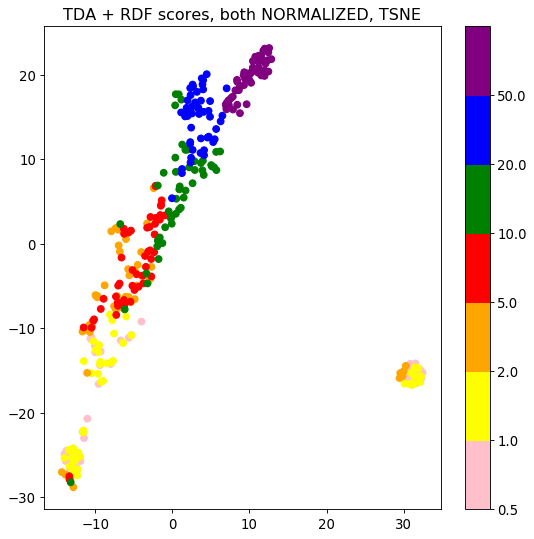

CPU times: user 20.8 s, sys: 424 ms, total: 21.3 s
Wall time: 1.94 s


In [88]:
%%time
scores1 = PCA(n_components=50).fit_transform(rdf_data)
scores2 = PCA(n_components=50).fit_transform(tda_data)
scores = normalize(np.concatenate([scores1, scores2, np.asarray(n_atoms_irr)[indxs][...,None]], axis=1))

X_emb = TSNE(n_components=2).fit_transform(scores)

label = np.ravel([[i]*nrun for i in range(len(pka_list))])[indxs]
colors = ['pink', 'yellow', 'orange', 'red','green','blue', 'purple']

fig = plt.figure(figsize=(8,8))
plt.scatter(X_emb[:,0], X_emb[:,1], c=label, cmap=matplotlib.colors.ListedColormap(colors))

cb = plt.colorbar()
loc = np.arange(0,max(label),max(label)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels([str(item/1000) for item in pka_list])

plt.title("TDA + RDF scores, both NORMALIZED, TSNE")
plt.show()

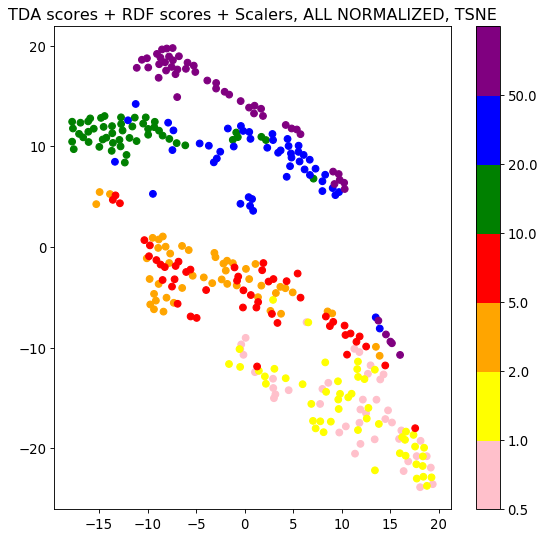

CPU times: user 23.2 s, sys: 792 ms, total: 24 s
Wall time: 2.22 s


In [89]:
%%time
scores1 = PCA(n_components=50).fit_transform(rdf_data)
scores2 = PCA(n_components=50).fit_transform(tda_data)
scores = normalize(np.concatenate([scores1, scores2, s_data[:,3:], np.asarray(n_atoms_irr)[indxs][...,None]], axis=1))

X_emb = TSNE(n_components=2).fit_transform(scores)

label = np.ravel([[i]*nrun for i in range(len(pka_list))])[indxs]
colors = ['pink', 'yellow', 'orange', 'red','green','blue', 'purple']

fig = plt.figure(figsize=(8,8))
plt.scatter(X_emb[:,0], X_emb[:,1], c=label, cmap=matplotlib.colors.ListedColormap(colors))

cb = plt.colorbar()
loc = np.arange(0,max(label),max(label)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels([str(item/1000) for item in pka_list])

plt.title("TDA scores + RDF scores + Scalers, ALL NORMALIZED, TSNE")
plt.show()

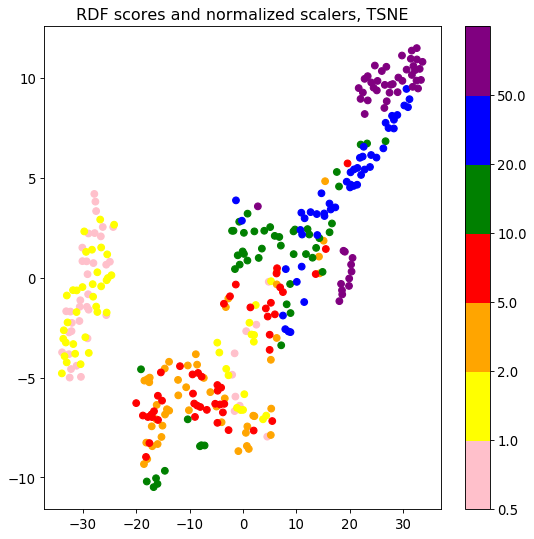

CPU times: user 14.5 s, sys: 702 ms, total: 15.2 s
Wall time: 1.04 s


In [90]:
%%time
scores = PCA(n_components=10).fit_transform(rdf_data)
x_data = np.concatenate([scores, normalize(s_data[:,3:], axis=0)], axis=1)
X_emb = TSNE(n_components=2).fit_transform(x_data)


label = np.ravel([[i]*nrun for i in range(len(pka_list))])[indxs]
colors = ['pink', 'yellow', 'orange', 'red','green','blue', 'purple']

fig = plt.figure(figsize=(8,8))
plt.scatter(X_emb[:,0], X_emb[:,1], c=label, cmap=matplotlib.colors.ListedColormap(colors))

cb = plt.colorbar()
loc = np.arange(0,max(label),max(label)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels([str(item/1000) for item in pka_list])

plt.title("RDF scores and normalized scalers, TSNE")
plt.show()

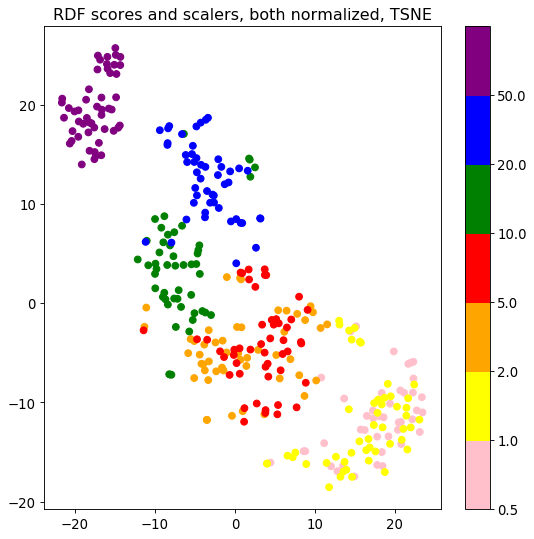

In [93]:
scores = PCA(n_components=10).fit_transform(rdf_data)
x_data = normalize(np.concatenate([scores, s_data[:,3:], np.asarray(n_atoms_irr)[indxs][...,None]], axis=1), axis=0)
X_emb = TSNE(n_components=2).fit_transform(x_data)


label = np.ravel([[i]*nrun for i in range(len(pka_list))])[indxs]
colors = ['pink', 'yellow', 'orange', 'red', 'green', 'blue', 'purple']

fig = plt.figure(figsize=(8,8))
plt.scatter(X_emb[:,0], X_emb[:,1], c=label, cmap=matplotlib.colors.ListedColormap(colors))

cb = plt.colorbar()
loc = np.arange(0,max(label),max(label)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels([str(item/1000) for item in pka_list])
plt.title("RDF scores and scalers, both normalized, TSNE")
plt.show()

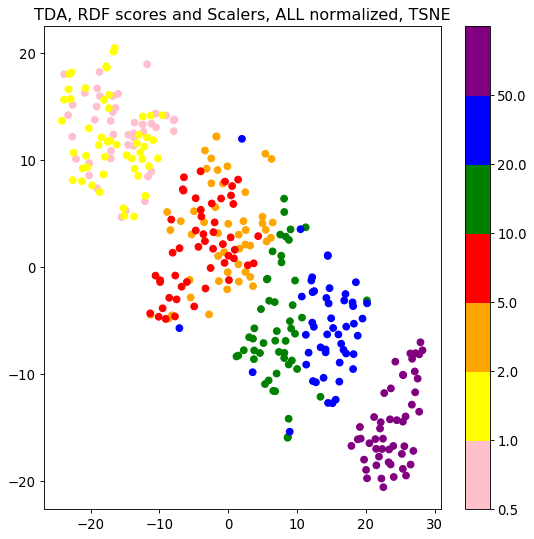

CPU times: user 20.7 s, sys: 528 ms, total: 21.2 s
Wall time: 1.84 s


In [94]:
%%time
scores1 = PCA(n_components=10).fit_transform(rdf_data)
scores2 = PCA(n_components=10).fit_transform(tda_data)
scores = np.concatenate([scores1, scores2], axis=1)

x_data = normalize(np.concatenate([scores, s_data[:,3:], np.asarray(n_atoms_irr)[indxs][...,None]], axis=1), axis=0)
X_emb = TSNE(n_components=2).fit_transform(x_data)


label = np.ravel([[i]*nrun for i in range(len(pka_list))])[indxs]
colors = ['pink', 'yellow', 'orange', 'red', 'green', 'blue', 'purple']

fig = plt.figure(figsize=(8,8))
plt.scatter(X_emb[:,0], X_emb[:,1], c=label, cmap=matplotlib.colors.ListedColormap(colors))

cb = plt.colorbar()
loc = np.arange(0,max(label),max(label)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels([str(item/1000) for item in pka_list])
plt.title("TDA, RDF scores and Scalers, ALL normalized, TSNE")
plt.show()

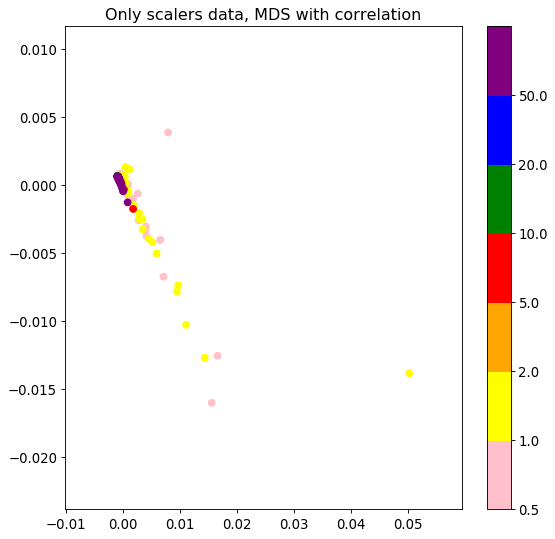

CPU times: user 1min 1s, sys: 377 ms, total: 1min 1s
Wall time: 7.77 s


In [95]:
%%time
x_data = np.concatenate([s_data[:,3:], np.asarray(n_atoms_irr)[indxs][...,None]], axis=1)
dmat = squareform(pdist(x_data, "correlation"))
seed = 29734
mds = MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=seed,
                   dissimilarity="precomputed", n_jobs=1)
X_emb = mds.fit(dmat).embedding_

label = np.ravel([[i]*nrun for i in range(len(pka_list))])[indxs]
colors = ['pink', 'yellow', 'orange', 'red','green','blue', 'purple']

fig = plt.figure(figsize=(8,8))
plt.scatter(X_emb[:,0], X_emb[:,1], c=label, cmap=matplotlib.colors.ListedColormap(colors))

cb = plt.colorbar()
loc = np.arange(0,max(label),max(label)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels([str(item/1000) for item in pka_list])

plt.title("Only scalers data, MDS with correlation")
plt.show()

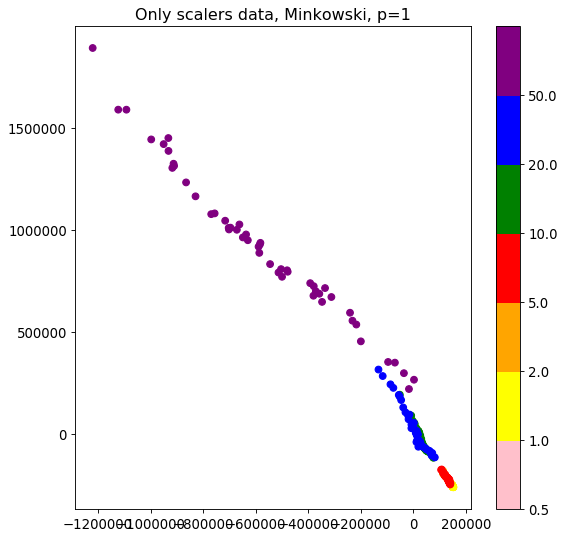

CPU times: user 1min 52s, sys: 704 ms, total: 1min 53s
Wall time: 14.3 s


In [98]:
%%time
x_data = np.concatenate([s_data[:,3:], np.asarray(n_atoms_irr)[indxs][...,None]], axis=1)
dmat = squareform(pdist(x_data, "minkowski", p=1))
seed = 29734
mds = MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=seed,
                   dissimilarity="precomputed", n_jobs=1)
X_emb = mds.fit(dmat).embedding_

label = np.ravel([[i]*nrun for i in range(len(pka_list))])[indxs]
colors = ['pink', 'yellow', 'orange', 'red','green','blue', 'purple']

fig = plt.figure(figsize=(8,8))
plt.scatter(X_emb[:,0], X_emb[:,1], c=label, cmap=matplotlib.colors.ListedColormap(colors))

cb = plt.colorbar()
loc = np.arange(0,max(label),max(label)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels([str(item/1000) for item in pka_list])

plt.title("Only scalers data, Minkowski, p=1")
plt.show()

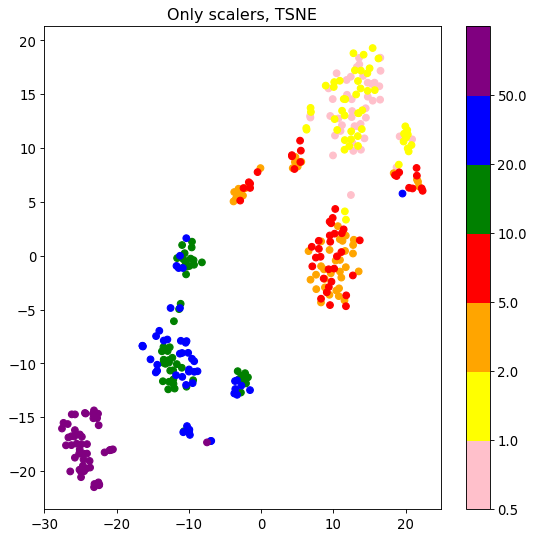

In [135]:
x_data = normalize(np.concatenate([s_data[:,3:], np.asarray(n_atoms_irr)[indxs][...,None]], axis=1), axis=0)
X_emb = TSNE(n_components=2).fit_transform(x_data)

label = np.ravel([[i]*nrun for i in range(len(pka_list))])[indxs]
colors = ['pink', 'yellow', 'orange', 'red', 'green', 'blue', 'purple']

fig = plt.figure(figsize=(8,8))
plt.scatter(X_emb[:,0], X_emb[:,1], c=label, cmap=matplotlib.colors.ListedColormap(colors))

cb = plt.colorbar()
loc = np.arange(0,max(label),max(label)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels([str(item/1000) for item in pka_list])
plt.title("Only scalers, TSNE")
plt.show()

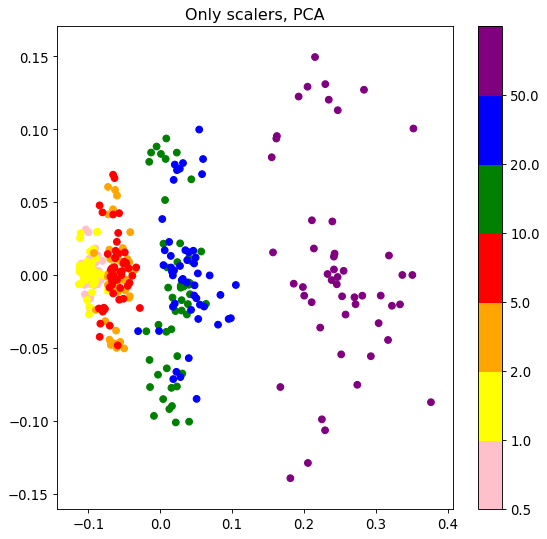

In [117]:
# x_data = normalize(s_data[:,3:], axis=0)
x_data = normalize(np.concatenate([s_data[:,3:], np.asarray(n_atoms_irr)[indxs][...,None]], axis=1), axis=0)
X_emb = PCA(n_components=2).fit_transform(x_data)

label = np.ravel([[i]*nrun for i in range(len(pka_list))])[indxs]
colors = ['pink', 'yellow', 'orange', 'red', 'green', 'blue', 'purple']

fig = plt.figure(figsize=(8,8))
plt.scatter(X_emb[:,0], X_emb[:,1], c=label, cmap=matplotlib.colors.ListedColormap(colors))

cb = plt.colorbar()
loc = np.arange(0,max(label),max(label)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels([str(item/1000) for item in pka_list])
plt.title("Only scalers, PCA")
plt.show()

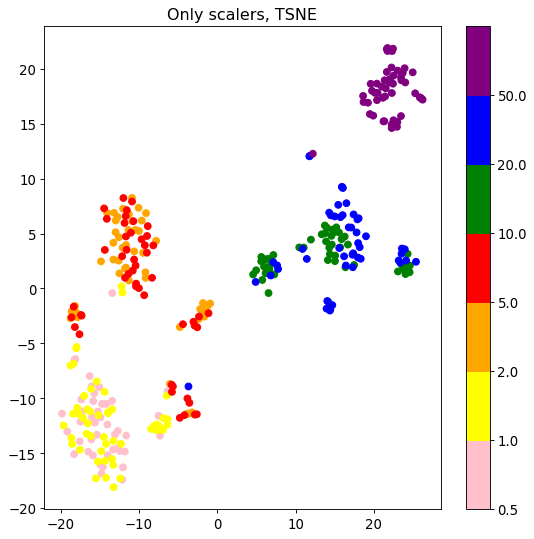

In [118]:
arr = normalize(np.concatenate([s_data[:,3:], np.asarray(n_atoms_irr)[indxs][...,None]], axis=1), axis=0)

X_emb = TSNE(n_components=2).fit_transform(arr)

label = np.ravel([[i]*nrun for i in range(len(pka_list))])[indxs]
colors = ['pink', 'yellow', 'orange', 'red', 'green', 'blue', 'purple']

fig = plt.figure(figsize=(8,8))
plt.scatter(X_emb[:,0], X_emb[:,1], c=label, cmap=matplotlib.colors.ListedColormap(colors))

cb = plt.colorbar()
loc = np.arange(0,max(label),max(label)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels([str(item/1000) for item in pka_list])
plt.title("Only scalers, TSNE")
plt.show()

## Model Construction using Scaler Metrics

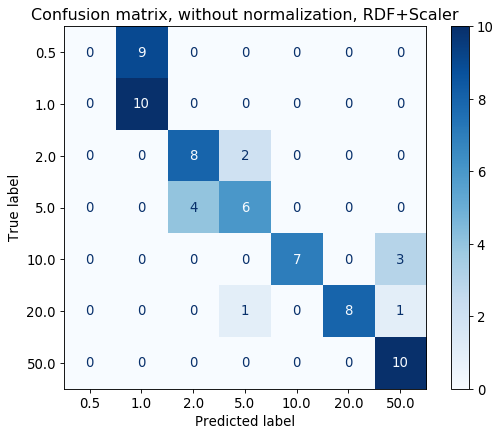

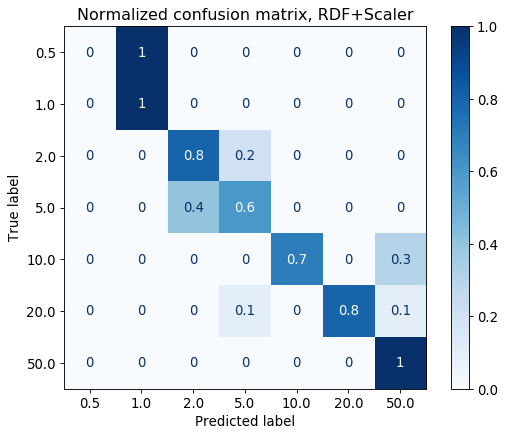

CPU times: user 1.88 s, sys: 41.9 ms, total: 1.92 s
Wall time: 511 ms


In [100]:
%%time
scores = PCA(n_components=10).fit_transform(rdf_data)

x_data = normalize(np.concatenate([scores, s_data[:,3:], np.asarray(n_atoms_irr)[indxs][...,None]], axis=1), axis=0)
label = np.concatenate([[0]*43] + [[i+1]*nrun for i in range(len(pka_list)-1)])

X_train, X_test, y_train, y_test = train_test_split(x_data, label, stratify=label, test_size=0.20, random_state=0)
clf = SVC(random_state=0, tol=1e-5, C=0.1)
clf.fit(X_train, y_train)

# Plot non-normalized confusion matrix
np.set_printoptions(precision=2)
titles_options = [("Confusion matrix, without normalization, RDF+Scaler", None),
                  ("Normalized confusion matrix, RDF+Scaler", 'true')]
for title, norm in titles_options:
    disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=[(item/1000) for item in pka_list],
                                 cmap=plt.cm.Blues,
                                 normalize=norm)
    disp.ax_.set_title(title)
plt.show()

In [113]:
from sklearn.mixture import GaussianMixture

In [118]:
%%time
scores = PCA(n_components=100).fit_transform(tda_data)

x_data = normalize(np.concatenate([scores, np.asarray(n_atoms_irr)[indxs][...,None]], axis=1), axis=0)
label = np.concatenate([[0]*43] + [[i+1]*nrun for i in range(len(pka_list)-1)])

X_train, X_test, y_train, y_test = train_test_split(x_data, label, stratify=label, test_size=0.20, random_state=0)



clf.fit(X_train, y_train)

# Plot non-normalized confusion matrix
np.set_printoptions(precision=2)
titles_options = [("Confusion matrix, without normalization, TDA", None),
                  ("Normalized confusion matrix, TDA", 'true')]
for title, norm in titles_options:
    disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=[(item/1000) for item in pka_list],
                                 cmap=plt.cm.Blues,
                                 normalize=norm)
    disp.ax_.set_title(title)
plt.show()

CPU times: user 11.9 s, sys: 773 ms, total: 12.7 s
Wall time: 2.17 s


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=7, n_init=1, precisions_init=None,
                random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [ ]:
https://github.com/michalkoziarski/DeterministicSubspace.git

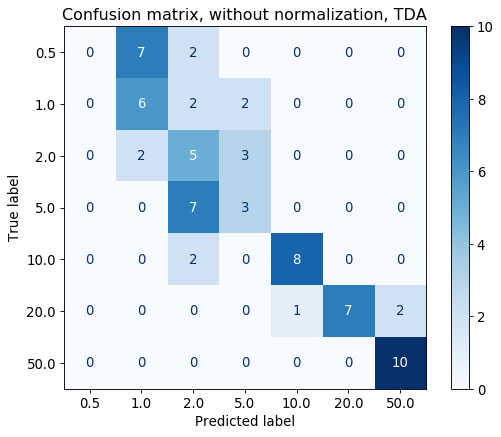

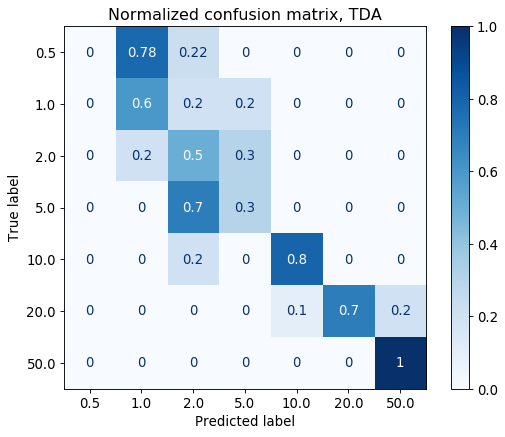

CPU times: user 4min 2s, sys: 2.01 s, total: 4min 4s
Wall time: 1min 11s


In [121]:
%%time
dmat = squareform(pdist(tda_data, "minkowski", p=1))
seed = 29734
mds = MDS(n_components=10, max_iter=5000, eps=1e-9, random_state=seed,
                   dissimilarity="precomputed", n_jobs=1)
scores = mds.fit(dmat).embedding_


x_data = normalize(np.concatenate([scores, np.asarray(n_atoms_irr)[indxs][...,None]], axis=1), axis=0)
label = np.concatenate([[0]*43] + [[i+1]*nrun for i in range(len(pka_list)-1)])

X_train, X_test, y_train, y_test = train_test_split(x_data, label, stratify=label, test_size=0.20, random_state=0)

clf = SVC(random_state=0, tol=1e-5, C=0.1)
clf.fit(X_train, y_train)

# Plot non-normalized confusion matrix
np.set_printoptions(precision=2)
titles_options = [("Confusion matrix, without normalization, TDA", None),
                  ("Normalized confusion matrix, TDA", 'true')]

for title, norm in titles_options:
    disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=[(item/1000) for item in pka_list],
                                 cmap=plt.cm.Blues,
                                 normalize=norm)
    disp.ax_.set_title(title)
plt.show()

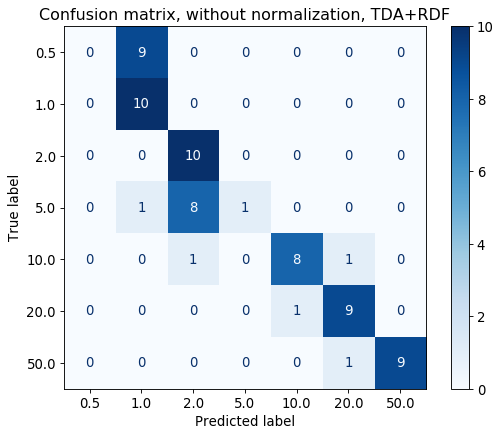

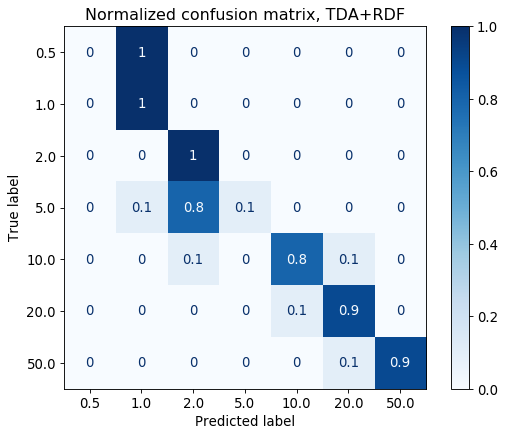

CPU times: user 6.39 s, sys: 239 ms, total: 6.63 s
Wall time: 1.25 s


In [128]:
%%time
scores1 = PCA(n_components=5).fit_transform(rdf_data)
scores2 = PCA(n_components=5).fit_transform(tda_data)
scores = np.concatenate([scores1, scores2], axis=1)

x_data = normalize(np.concatenate([scores, np.asarray(n_atoms_irr)[indxs][...,None]], axis=1), axis=0)
label = np.concatenate([[0]*43] + [[i+1]*nrun for i in range(len(pka_list)-1)])

X_train, X_test, y_train, y_test = train_test_split(x_data, label, stratify=label, test_size=0.20, random_state=0)
clf = SVC(random_state=0, tol=1e-5, C=0.1)
clf.fit(X_train, y_train)

# Plot non-normalized confusion matrix
np.set_printoptions(precision=2)
titles_options = [("Confusion matrix, without normalization, TDA+RDF", None),
                  ("Normalized confusion matrix, TDA+RDF", 'true')]
for title, norm in titles_options:
    disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=[(item/1000) for item in pka_list],
                                 cmap=plt.cm.Blues,
                                 normalize=norm)
    disp.ax_.set_title(title)
plt.show()

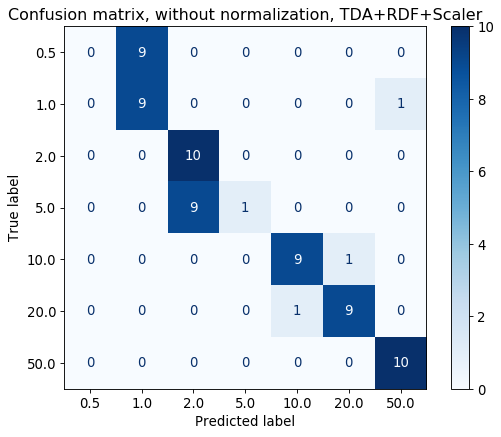

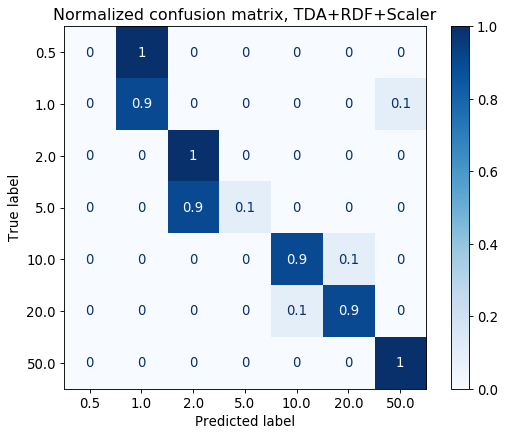

CPU times: user 6.42 s, sys: 241 ms, total: 6.66 s
Wall time: 1.29 s


In [129]:
%%time
scores1 = PCA(n_components=5).fit_transform(rdf_data)
scores2 = PCA(n_components=5).fit_transform(tda_data)
scores = np.concatenate([scores1, scores2], axis=1)

x_data = normalize(np.concatenate([scores, s_data[:,3:], np.asarray(n_atoms_irr)[indxs][...,None]], axis=1), axis=0)
label = np.concatenate([[0]*43] + [[i+1]*nrun for i in range(len(pka_list)-1)])

X_train, X_test, y_train, y_test = train_test_split(x_data, label, stratify=label, test_size=0.20, random_state=0)
clf = SVC(random_state=0, tol=1e-5, C=0.1)
clf.fit(X_train, y_train)

# Plot non-normalized confusion matrix
np.set_printoptions(precision=2)
titles_options = [("Confusion matrix, without normalization, TDA+RDF+Scaler", None),
                  ("Normalized confusion matrix, TDA+RDF+Scaler", 'true')]
for title, norm in titles_options:
    disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=[(item/1000) for item in pka_list],
                                 cmap=plt.cm.Blues,
                                 normalize=norm)
    disp.ax_.set_title(title)
plt.show()

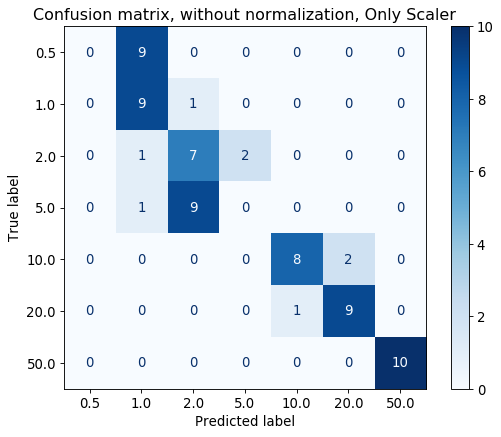

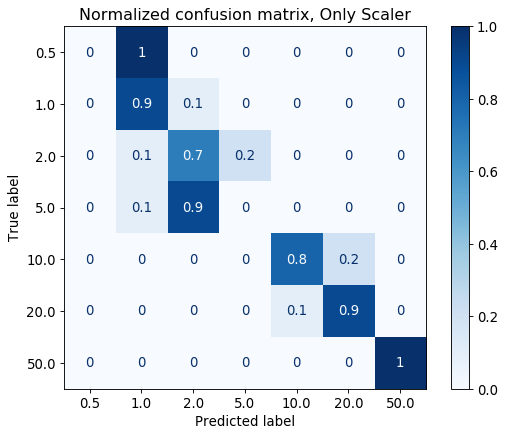

CPU times: user 469 ms, sys: 27 ms, total: 496 ms
Wall time: 495 ms


In [102]:
%%time
# x_data = normalize(s_data[:,3:], axis=0)
x_data = normalize(np.concatenate([s_data[:,3:], np.asarray(n_atoms_irr)[indxs][...,None]], axis=1), axis=0)


label = np.concatenate([[0]*43] + [[i+1]*nrun for i in range(len(pka_list)-1)])

X_train, X_test, y_train, y_test = train_test_split(x_data, label, stratify=label, test_size=0.20, random_state=0)
clf = SVC(random_state=0, tol=1e-5, C=0.1)
clf.fit(X_train, y_train)

# Plot non-normalized confusion matrix
np.set_printoptions(precision=2)
titles_options = [("Confusion matrix, without normalization, Only Scaler", None),
                  ("Normalized confusion matrix, Only Scaler", 'true')]
for title, norm in titles_options:
    disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=[(item/1000) for item in pka_list],
                                 cmap=plt.cm.Blues,
                                 normalize=norm)
    disp.ax_.set_title(title)
plt.show()

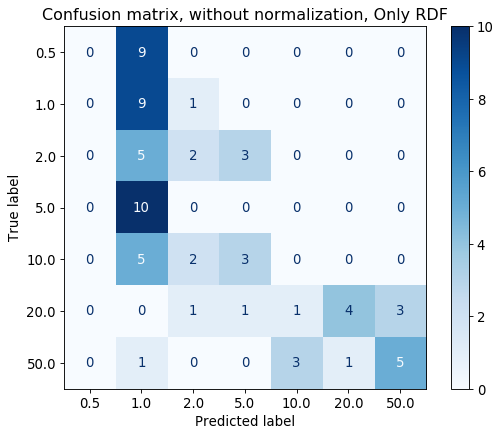

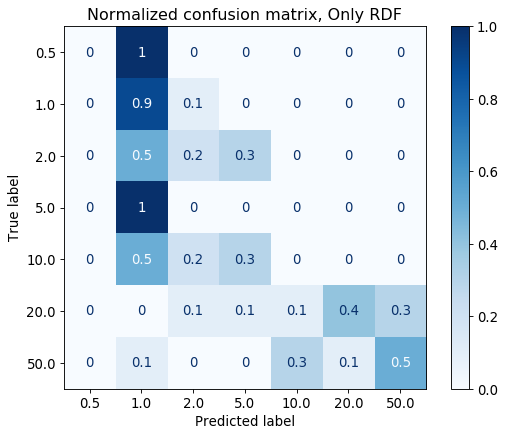

CPU times: user 934 ms, sys: 31 ms, total: 965 ms
Wall time: 965 ms


In [103]:
%%time
x_data = rdf_data.copy()
label = np.concatenate([[0]*43] + [[i+1]*nrun for i in range(len(pka_list)-1)])

X_train, X_test, y_train, y_test = train_test_split(x_data, label, stratify=label, test_size=0.20)
clf = SVC(random_state=0, tol=1e-5, C=0.1)
clf.fit(X_train, y_train)

# Plot non-normalized confusion matrix
np.set_printoptions(precision=2)
titles_options = [("Confusion matrix, without normalization, Only RDF", None),
                  ("Normalized confusion matrix, Only RDF", 'true')]
for title, norm in titles_options:
    disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=[(item/1000) for item in pka_list],
                                 cmap=plt.cm.Blues,
                                 normalize=norm)
    disp.ax_.set_title(title)
plt.show()